## Rental Price Prediction

1. Data Preprocessing
   - Missing value treatment
   - Outlier treatment
   - Double record check

2. Feature Engineering
   - Building new features like property age, renovation age

3. Final Feature Set
   - Convert the noisy textual fields to clean text
   - Categorical encoding
   - Finding feature importance via SHAP

4. Distribution and Correlation Analysis
   - How rental values and other quantitative features are distributed
   - How other features are correlated to the total rent
   
5. Rent Prediction without Textual Description Fields
   - XGB is the winner
   - SHAP Interpretation

6. Rent Prediction with Textual Description Fields

   - TF-IDF
   - BERT with Auxiliary Features

In [ ]:
pip install -U nltk

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import xgboost
import shap
import re
import nltk
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import seaborn as sns
import scipy
from math import sqrt
from scipy import stats
from datetime import date
from sklearn.impute import KNNImputer
import numpy as np
import random

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.metrics import sensitivity_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Preprocessing

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/immo_data.csv', encoding="ISO-8859-1")
df.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,SchÃ¼ren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,BÃ¶hl_Iggelheim,Alles neu macht der Mai â so kann es auch fÃ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,ÃuÃere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,* 9 mÂ² Balkon\n* Bad mit bodengleicher Dusche...,NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von LÃ¤rm und Abgasen in Ihre neue Woh...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [ ]:
df.shape

(268850, 49)

In [ ]:
df.nunique()

regio1                          16
serviceCharge                12266
heatingType                     13
telekomTvOffer                   3
telekomHybridUploadSpeed         1
newlyConst                       2
balcony                          2
picturecount                    95
pricetrend                    1234
telekomUploadSpeed               7
totalRent                    28486
yearConstructed                465
scoutId                     268850
noParkSpaces                    71
firingTypes                    132
hasKitchen                       2
geo_bln                         16
cellar                           2
yearConstructedRange             9
baseRent                     26659
houseNumber                   5510
livingSpace                  13005
geo_krs                        419
condition                       10
interiorQual                     4
petsAllowed                      3
street                       52373
streetPlain                  54490
lift                

## Missing Values

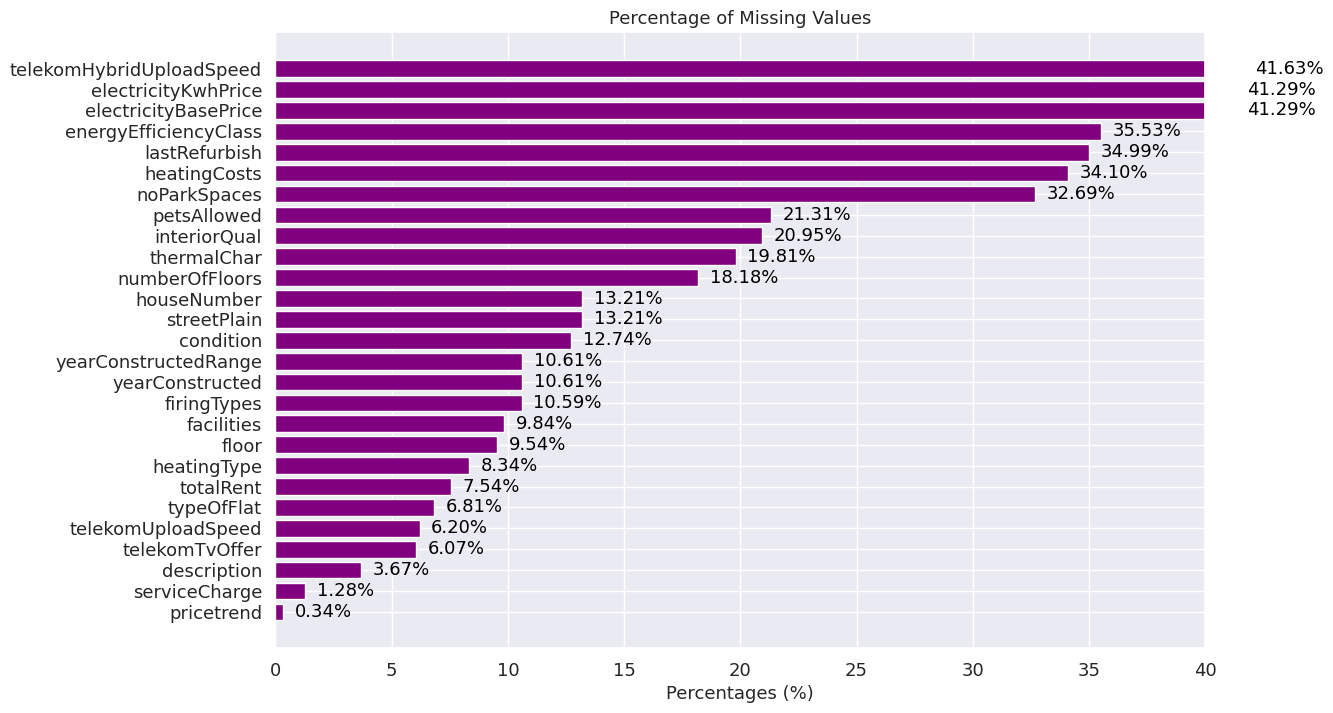

In [ ]:
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(16, 10)})

missing_data = df.isnull().sum()
fig, ax = plt.subplots(figsize=(12, 8))
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 50
missing_percentage.sort_values(ascending=True, inplace=True)
ax.barh(missing_percentage.index, missing_percentage, color='Purple')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontsize=13, color='black')

ax.set_xlim([0, 40])
ax.tick_params(axis='both',labelsize=13)
plt.title("Percentage of Missing Values", fontsize=13)
plt.xlabel('Percentages (%)', fontsize=13)
plt.show()

## Value Control

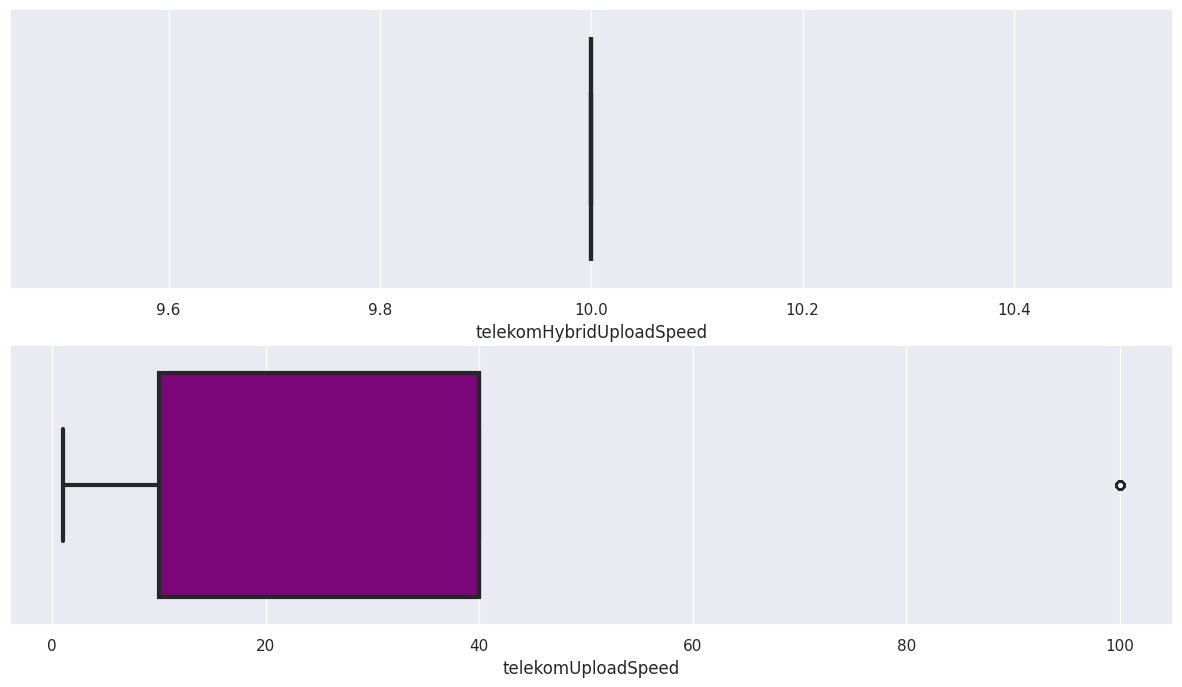

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15, 8))
sns.boxplot(ax=axes[0],data=df, x='telekomHybridUploadSpeed', linewidth=3,saturation=0.9, color= 'Purple')
sns.boxplot(ax=axes[1], data=df, x='telekomUploadSpeed', linewidth=3,saturation=0.9, color= 'Purple')
plt.show()

In [ ]:
df.drop( columns= ['telekomHybridUploadSpeed', 'electricityBasePrice', 'electricityKwhPrice', 'energyEfficiencyClass', 'petsAllowed', 'houseNumber'], inplace= True)

## Check Duplicates

In [ ]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,...,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,lastRefurbish,date


## Numerical Features

In [ ]:
numeric_columns=  ['totalRent', 'baseRent', 'livingSpace',   'serviceCharge', 'heatingCosts',
                     'thermalChar', 'noRoomsRange', 'livingSpaceRange','noRooms', 'noParkSpaces', 'floor', 'numberOfFloors',
                    'picturecount','pricetrend', 'baseRentRange', 'telekomUploadSpeed',  'lastRefurbish',  'yearConstructedRange', 'yearConstructed']

df[numeric_columns]= df[numeric_columns].astype(float)

## Round Values

In [ ]:
def round_val(x):
    return round(x)

for i in numeric_columns:
     df[i].fillna(df[i].mean(), inplace=True)

df[numeric_columns]= df[numeric_columns].apply(lambda x: round(x) )
cat_columns= list( set(df.columns) - set(numeric_columns))
df_num= df[['scoutId']+numeric_columns]

df_num

,scoutId,totalRent,baseRent,livingSpace,serviceCharge,heatingCosts,thermalChar,noRoomsRange,livingSpaceRange,noRooms,noParkSpaces,floor,numberOfFloors,picturecount,pricetrend,baseRentRange,telekomUploadSpeed,lastRefurbish,yearConstructedRange,yearConstructed
0,96107057,840.0,595.0,86.0,245.0,77.0,181.0,4.0,4.0,4.0,1.0,1.0,3.0,6.0,5.0,4.0,10.0,2014.0,2.0,1965.0
1,111378734,901.0,800.0,89.0,134.0,77.0,115.0,3.0,4.0,3.0,2.0,2.0,4.0,8.0,3.0,5.0,10.0,2019.0,1.0,1871.0
2,113147523,1300.0,965.0,84.0,255.0,77.0,115.0,3.0,4.0,3.0,1.0,3.0,4.0,8.0,3.0,6.0,2.0,2014.0,9.0,2019.0
3,108890903,901.0,343.0,58.0,58.0,87.0,86.0,3.0,2.0,3.0,1.0,3.0,4.0,9.0,2.0,2.0,40.0,2014.0,2.0,1964.0
4,114751222,903.0,765.0,85.0,138.0,77.0,189.0,3.0,4.0,3.0,1.0,1.0,4.0,19.0,2.0,5.0,29.0,2014.0,1.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,115641081,910.0,820.0,90.0,90.0,77.0,115.0,3.0,4.0,3.0,1.0,2.0,4.0,0.0,3.0,6.0,10.0,2014.0,9.0,2016.0
268846,96981497,1150.0,930.0,115.0,220.0,77.0,115.0,3.0,5.0,4.0,1.0,1.0,1.0,12.0,6.0,6.0,29.0,2015.0,4.0,1983.0
268847,66924271,930.0,650.0,95.0,220.0,77.0,161.0,4.0,4.0,4.0,1.0,1.0,2.0,21.0,3.0,5.0,40.0,2019.0,2.0,1965.0
268848,110938302,1015.0,840.0,70.0,175.0,40.0,25.0,2.0,3.0,2.0,1.0,2.0,5.0,16.0,4.0,6.0,29.0,2019.0,9.0,2019.0


## Feature Engineering

In [ ]:
today = date.today()
df_num['yearConstructed']= df_num['yearConstructed'].astype(int)
df_num['lastRefurbish']= df_num['lastRefurbish'].astype(int)

df_num['property_age']= int(today.year)- df_num['yearConstructed']
df_num['refurbish_age']= int(today.year)- df_num['lastRefurbish']

df_num.drop( columns= ['yearConstructed', 'lastRefurbish'], inplace= True)
numeric_columns = list( set(df_num.columns)- set(['yearConstructed', 'lastRefurbish']) )

## Value Control

In [ ]:
print('min base rent:', df['baseRent'].min(), '       max base rent:', df['baseRent'].max ())
print('min total rent:', df['totalRent'].min(), '       max total rent:', df['totalRent'].max ())

min base rent: 0.0        max base rent: 9999999.0
min total rent: 0.0        max total rent: 15751535.0


In [ ]:
df_num[numeric_columns].describe().round(2)

,noRooms,numberOfFloors,livingSpaceRange,baseRent,refurbish_age,baseRentRange,scoutId,telekomUploadSpeed,thermalChar,pricetrend,noParkSpaces,totalRent,yearConstructedRange,livingSpace,picturecount,noRoomsRange,serviceCharge,property_age,floor,heatingCosts
count,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,2.688500e+05,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00,268850.00
mean,2.64,3.73,3.07,694.13,10.03,3.77,1.069697e+08,28.77,114.85,3.40,1.11,901.28,3.78,74.36,9.79,2.57,151.20,57.68,2.10,77.00
std,2.64,5.09,1.41,19536.02,6.01,2.21,1.250093e+07,15.40,47.91,1.97,4.92,30631.51,2.43,254.76,6.41,0.94,304.31,41.71,3.27,83.31
min,1.00,0.00,1.00,0.00,-895.00,1.00,2.887174e+07,1.00,0.00,-12.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,-66.00,-1.00,0.00
25%,2.00,3.00,2.00,338.00,10.00,2.00,1.066910e+08,10.00,98.00,2.00,1.00,495.00,2.00,54.00,6.00,2.00,96.00,32.00,1.00,77.00
50%,3.00,4.00,3.00,490.00,10.00,3.00,1.111584e+08,40.00,115.00,3.00,1.00,741.00,4.00,67.00,9.00,3.00,140.00,58.00,2.00,77.00
75%,3.00,4.00,4.00,799.00,10.00,5.00,1.137688e+08,40.00,117.00,5.00,1.00,901.00,5.00,87.00,13.00,3.00,185.00,66.00,3.00,77.00
max,1000.00,999.00,7.00,9999999.00,1009.00,9.00,1.157117e+08,100.00,1996.00,15.00,2241.00,15751535.00,9.00,111111.00,121.00,5.00,146118.00,1024.00,999.00,12613.00


In [ ]:
df_num[df_num['totalRent']==0]
df_num[df_num['totalRent']==0].head(8)

,scoutId,totalRent,baseRent,livingSpace,serviceCharge,heatingCosts,thermalChar,noRoomsRange,livingSpaceRange,noRooms,noParkSpaces,floor,numberOfFloors,picturecount,pricetrend,baseRentRange,telekomUploadSpeed,yearConstructedRange,property_age,refurbish_age
1119,94258021,0.0,210.0,50.0,105.0,77.0,115.0,2.0,2.0,2.0,1.0,1.0,1.0,10.0,-1.0,1.0,2.0,3.0,51,10
1883,111407942,0.0,295.0,40.0,75.0,0.0,103.0,1.0,1.0,1.0,0.0,2.0,0.0,6.0,4.0,1.0,40.0,2.0,60,10
4209,105929235,0.0,245.0,45.0,100.0,77.0,96.0,2.0,2.0,2.0,1.0,2.0,2.0,15.0,0.0,1.0,2.0,1.0,94,10
5035,113014387,0.0,240.0,50.0,100.0,77.0,140.0,2.0,2.0,2.0,1.0,1.0,1.0,13.0,1.0,1.0,40.0,2.0,64,10
5739,94257790,0.0,220.0,63.0,75.0,77.0,41.0,3.0,3.0,3.0,1.0,3.0,3.0,9.0,-1.0,1.0,40.0,4.0,35,10
7188,112149527,0.0,750.0,105.0,185.0,77.0,164.0,3.0,5.0,3.0,2.0,2.0,2.0,25.0,2.0,5.0,10.0,4.0,42,14
7692,54286562,0.0,1100.0,150.0,375.0,0.0,115.0,4.0,6.0,4.0,1.0,1.0,1.0,6.0,3.0,7.0,40.0,6.0,19,10
8914,74292006,0.0,290.0,34.0,85.0,77.0,86.0,1.0,1.0,1.0,1.0,0.0,2.0,4.0,3.0,1.0,40.0,2.0,57,5


## Rent Value Control

In [ ]:
for col in numeric_columns:
    df_num= df_num[df_num[col]>0]

df_num= df_num[df_num['totalRent']>df_num['baseRent']]
df_num= df_num[df_num['baseRent']>100]
df_num.head(8)

,scoutId,totalRent,baseRent,livingSpace,serviceCharge,heatingCosts,thermalChar,noRoomsRange,livingSpaceRange,noRooms,noParkSpaces,floor,numberOfFloors,picturecount,pricetrend,baseRentRange,telekomUploadSpeed,yearConstructedRange,property_age,refurbish_age
0,96107057,840.0,595.0,86.0,245.0,77.0,181.0,4.0,4.0,4.0,1.0,1.0,3.0,6.0,5.0,4.0,10.0,2.0,59,10
1,111378734,901.0,800.0,89.0,134.0,77.0,115.0,3.0,4.0,3.0,2.0,2.0,4.0,8.0,3.0,5.0,10.0,1.0,153,5
2,113147523,1300.0,965.0,84.0,255.0,77.0,115.0,3.0,4.0,3.0,1.0,3.0,4.0,8.0,3.0,6.0,2.0,9.0,5,10
3,108890903,901.0,343.0,58.0,58.0,87.0,86.0,3.0,2.0,3.0,1.0,3.0,4.0,9.0,2.0,2.0,40.0,2.0,60,10
4,114751222,903.0,765.0,85.0,138.0,77.0,189.0,3.0,4.0,3.0,1.0,1.0,4.0,19.0,2.0,5.0,29.0,1.0,74,10
5,115531145,901.0,315.0,53.0,142.0,77.0,165.0,2.0,2.0,2.0,1.0,2.0,4.0,5.0,4.0,2.0,2.0,5.0,25,10
6,114391930,380.0,310.0,62.0,70.0,77.0,115.0,2.0,3.0,2.0,1.0,1.0,4.0,9.0,1.0,2.0,2.0,4.0,58,10
7,115270775,584.0,452.0,60.0,88.0,44.0,63.0,3.0,2.0,3.0,1.0,2.0,4.0,5.0,2.0,3.0,2.0,2.0,65,10


## Distributions

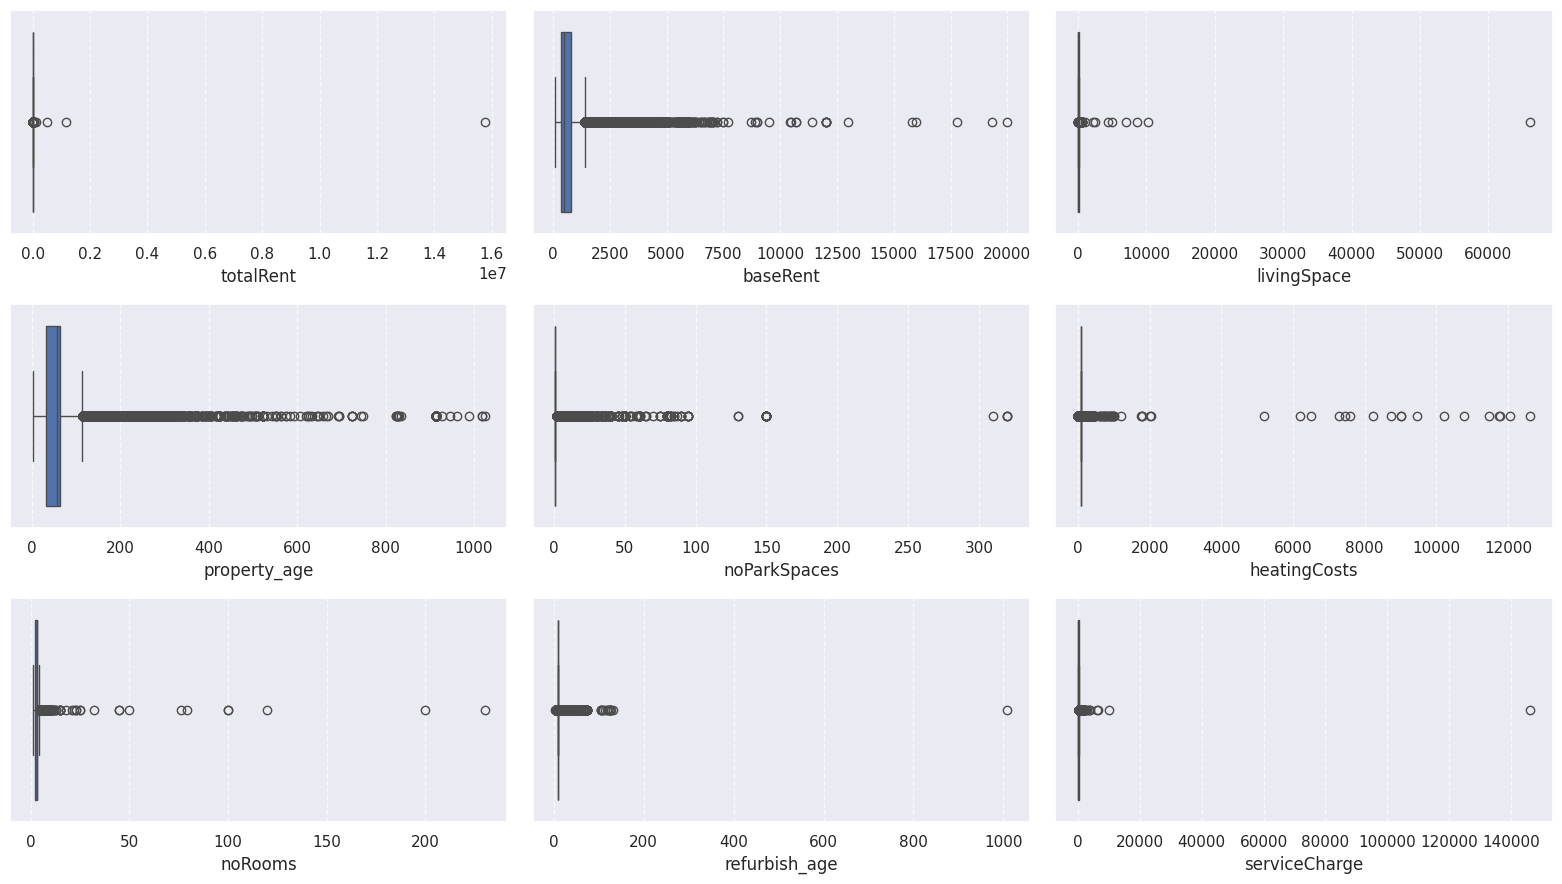

In [ ]:
sns.set(font_scale=1.0)
sns.set(rc={'figure.figsize':(17, 7)})
fig, axes = plt.subplots(3, 3, figsize=(16, 9))

axes[0, 0].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 2].grid(True, linestyle='--', alpha=0.7)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].grid(True, linestyle='--', alpha=0.7)
axes[2, 0].grid(True, linestyle='--', alpha=0.7)
axes[2, 1].grid(True, linestyle='--', alpha=0.7)
axes[2, 2].grid(True, linestyle='--', alpha=0.7)

sns.boxplot(ax=axes[0, 0], data=df_num, x='totalRent', linewidth=1 ,saturation=0.9)
sns.boxplot(ax=axes[0, 1], data=df_num, x='baseRent', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[0, 2], data=df_num, x='livingSpace', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[1, 0], data=df_num, x='property_age', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[1, 1], data=df_num, x='noParkSpaces', linewidth=1 ,saturation=0.9)
sns.boxplot(ax=axes[1, 2], data=df_num, x='heatingCosts', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 0], data=df_num, x='noRooms', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 1], data=df_num, x='refurbish_age', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 2], data=df_num, x='serviceCharge', linewidth=1,saturation=0.9)

fig.tight_layout()
plt.show()

## Outlier Treatment

In [ ]:
df_num= df_num[ (df_num['totalRent'] < df_num['totalRent'].quantile(0.95)) &
                ( df_num['baseRent'] < df_num['baseRent'].quantile(0.95))&
                ( df_num['livingSpace'] < df_num['livingSpace'].quantile(0.95))&
                ( df_num['serviceCharge'] < df_num['serviceCharge'].quantile(0.95))&
                ( df_num['heatingCosts'] < df_num['heatingCosts'].quantile(0.95))&
                ( df_num['thermalChar'] < df_num['thermalChar'].quantile(0.95))&
                ( df_num['noRooms'] < df_num['noRooms'].quantile(0.95))&
                ( df_num['property_age'] < df_num['property_age'].quantile(0.95))&
                ( df_num['refurbish_age'] < df_num['refurbish_age'].quantile(0.95))&
                ( df_num['floor'] < df_num['floor'].quantile(0.95))&
                ( df_num['numberOfFloors'] < df_num['numberOfFloors'].quantile(0.95))
                ]

print('min base rent:', df_num['baseRent'].min(), '       max base rent:', df_num['baseRent'].max ())
print('min total rent:', df_num['totalRent'].min(), '       max total rent:', df_num['totalRent'].max ())

min base rent: 103.0        max base rent: 1455.0
min total rent: 130.0        max total rent: 1749.0


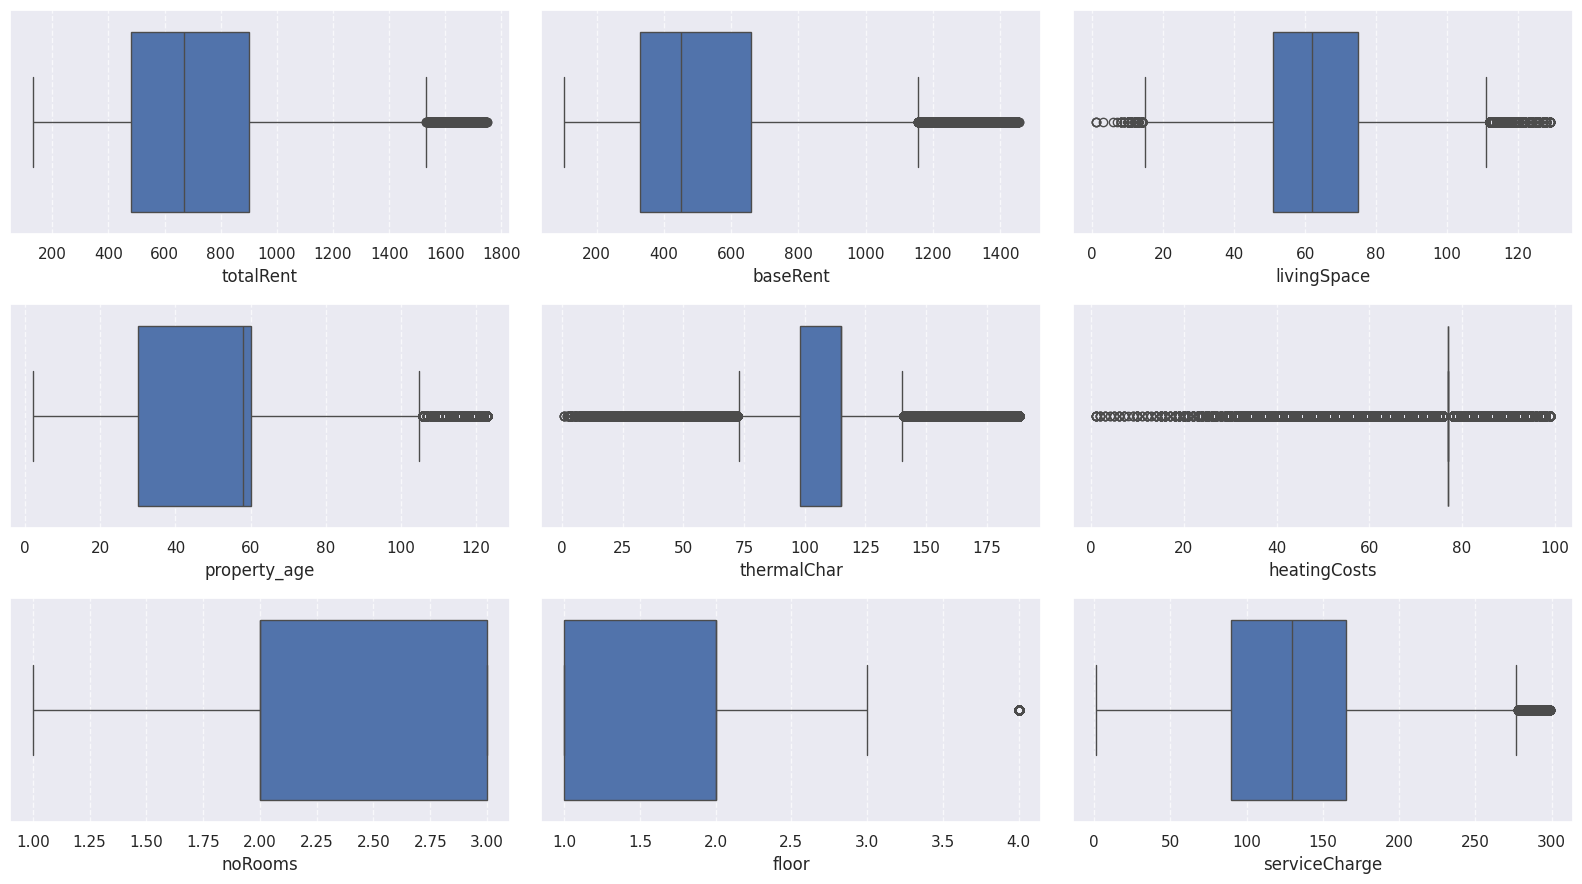

In [ ]:
sns.set(font_scale=1.0)
sns.set(rc={'figure.figsize':(17, 7)})
fig, axes = plt.subplots(3, 3, figsize=(16, 9))

axes[0, 0].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 2].grid(True, linestyle='--', alpha=0.7)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].grid(True, linestyle='--', alpha=0.7)
axes[2, 0].grid(True, linestyle='--', alpha=0.7)
axes[2, 1].grid(True, linestyle='--', alpha=0.7)
axes[2, 2].grid(True, linestyle='--', alpha=0.7)

sns.boxplot(ax=axes[0, 0], data=df_num, x='totalRent', linewidth=1 ,saturation=0.9)
sns.boxplot(ax=axes[0, 1], data=df_num, x='baseRent', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[0, 2], data=df_num, x='livingSpace', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[1, 0], data=df_num, x='property_age', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[1, 1], data=df_num, x='thermalChar', linewidth=1 ,saturation=0.9)
sns.boxplot(ax=axes[1, 2], data=df_num, x='heatingCosts', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 0], data=df_num, x='noRooms', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 1], data=df_num, x='floor', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 2], data=df_num, x='serviceCharge', linewidth=1,saturation=0.9)

fig.tight_layout()
plt.show()

In [ ]:
df_cat= df[cat_columns]
df_mix = pd.merge(df_num, df_cat, on='scoutId')
df_mix= df_mix.dropna()

df_mix.reset_index(drop=True, inplace=True)
df_mix.head(5)

,scoutId,totalRent,baseRent,livingSpace,serviceCharge,heatingCosts,thermalChar,noRoomsRange,livingSpaceRange,noRooms,...,geo_krs,regio2,cellar,condition,hasKitchen,street,telekomTvOffer,regio1,heatingType,date
0,111337159,760.0,620.0,56.0,140.0,77.0,142.0,3.0,2.0,3.0,...,Hamburg,Hamburg,True,fully_renovated,False,B&ouml;melburgweg,ONE_YEAR_FREE,Hamburg,central_heating,May19
1,112400650,535.0,365.0,79.0,170.0,77.0,101.0,3.0,3.0,3.0,...,Zwickau_Kreis,Zwickau_Kreis,True,well_kept,False,Friedrich Engels Stra&szlig;e,ONE_YEAR_FREE,Sachsen,gas_heating,Feb20
2,113704695,1300.0,1150.0,46.0,150.0,77.0,115.0,2.0,2.0,2.0,...,Berlin,Berlin,True,first_time_use,True,Stallschreiberstra&szlig;e,ONE_YEAR_FREE,Berlin,floor_heating,Oct19
3,53976835,499.0,339.0,55.0,70.0,60.0,115.0,2.0,2.0,2.0,...,Leipzig,Leipzig,True,refurbished,True,Wilhelm-Busch-Stra&szlig;e,ONE_YEAR_FREE,Sachsen,central_heating,Sep18
4,115672272,412.0,285.0,54.0,127.0,77.0,115.0,2.0,2.0,2.0,...,Remscheid,Remscheid,True,first_time_use_after_refurbishment,False,Feilenhauerweg,ONE_YEAR_FREE,Nordrhein_Westfalen,self_contained_central_heating,Feb20


## Feature Text Cleaning

In [ ]:
df_mix[['regio1', 'regio2',  'geo_bln', 'geo_krs', 'streetPlain', 'regio3', 'street']]

,regio1,regio2,geo_bln,geo_krs,streetPlain,regio3,street
0,Hamburg,Hamburg,Hamburg,Hamburg,BÃ¶melburgweg,Horn,B&ouml;melburgweg
1,Sachsen,Zwickau_Kreis,Sachsen,Zwickau_Kreis,Friedrich_Engels_StraÃe,Hohenstein_Ernstthal,Friedrich Engels Stra&szlig;e
2,Berlin,Berlin,Berlin,Berlin,StallschreiberstraÃe,Mitte_Mitte,Stallschreiberstra&szlig;e
3,Sachsen,Leipzig,Sachsen,Leipzig,Wilhelm-Busch-StraÃe,Mockau_SÃ¼d,Wilhelm-Busch-Stra&szlig;e
4,Nordrhein_Westfalen,Remscheid,Nordrhein_Westfalen,Remscheid,Feilenhauerweg,Zentralpunkt,Feilenhauerweg
...,...,...,...,...,...,...,...
24854,Rheinland_Pfalz,Rhein_HunsrÃ¼ck_Kreis,Rheinland_Pfalz,Rhein_HunsrÃ¼ck_Kreis,Henchenstr.,Emmelshausen,Henchenstr.
24855,Nordrhein_Westfalen,Mettmann_Kreis,Nordrhein_Westfalen,Mettmann_Kreis,Benzenbergweg,Haan,Benzenbergweg
24856,Niedersachsen,Hannover_Kreis,Niedersachsen,Hannover_Kreis,Bissendorfer_StraÃe,Wedemark,Bissendorfer Stra&szlig;e
24857,Nordrhein_Westfalen,Neuss_Rhein_Kreis,Nordrhein_Westfalen,Neuss_Rhein_Kreis,Further_Str._,Neuss,Further Str.


In [ ]:
def clean_feat(text):

    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'\s+', ' ', text).strip()
    text= re.sub(r'[0-9]+', '',text)

    return text


for col in ['regio1', 'regio2',  'geo_bln', 'geo_krs', 'streetPlain', 'regio3', 'street']:
    df_mix[col]=df_mix[col].apply(lambda x: clean_feat(str(x)))

df_mix[['regio1', 'regio2',  'geo_bln', 'geo_krs', 'streetPlain', 'regio3', 'street']].head(8)

,regio1,regio2,geo_bln,geo_krs,streetPlain,regio3,street
0,hamburg,hamburg,hamburg,hamburg,b melburgweg,horn,b ouml melburgweg
1,sachsen,zwickau kreis,sachsen,zwickau kreis,friedrich engels stra e,hohenstein ernstthal,friedrich engels stra szlig e
2,berlin,berlin,berlin,berlin,stallschreiberstra e,mitte mitte,stallschreiberstra szlig e
3,sachsen,leipzig,sachsen,leipzig,wilhelm busch stra e,mockau s d,wilhelm busch stra szlig e
4,nordrhein westfalen,remscheid,nordrhein westfalen,remscheid,feilenhauerweg,zentralpunkt,feilenhauerweg
5,hessen,wetteraukreis,hessen,wetteraukreis,arthur weber weg,bad nauheim,arthur weber weg
6,sachsen,dresden,sachsen,dresden,hartigstrasse,pieschen s d,hartigstrasse
7,nordrhein westfalen,wuppertal,nordrhein westfalen,wuppertal,ernststra e,elberfeld west,ernststra szlig e


## Description Text Cleaning

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

german_stopwords = set(stopwords.words('german'))

def clean_text(text):

    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"(#[\d\w\.]+)", '', text)
    text = re.sub(r"(@[\d\w\.]+)", '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'\s+', ' ', text).strip()
    text= re.sub(r'[0-9]+', '',text)

    text= text.lower()

    word_list= [word for word in text.split() if len(word)>3]

    cleaned_text = ' '.join([word for word in word_list if word not in german_stopwords])

    return cleaned_text

df_mix["clean_description"] = df_mix["description"].apply(lambda x: clean_text(str(x)))
df_mix["clean_facilities"] = df_mix["facilities"].apply(lambda x: clean_text(str(x)))

df_mix[["clean_description","description", "clean_facilities", "facilities"]].head(10)

,clean_description,description,clean_facilities,facilities
0,freuen grundsanierte wohnung decken gespachtel...,Freuen Sie sich auf diese grundsanierte Wohnun...,kabelanschluss warmwasser zentral heizanlage k...,Kabelanschluss; Warmwasser zentral (Ã¼ber Heiz...
1,laminatboden wohn schlafr umen boden fenster w...,ï¼ Laminatboden in den Wohn-und SchlafrÃ¤umen...,vermietung steht obergescho gepflegten familie...,"Zur Vermietung steht hier im 1. ObergeschoÃ, ..."
2,luxuri neubauquartier direkt luisenpark giger ...,Dieses luxuriÃ¶se Neubauquartier direkt am Lui...,ruhig gelegen trotz zentraler lage zimmer park...,"â¢ sehr ruhig gelegen, trotz zentraler Lage, ..."
3,zimmer wohnung zentraler lage leipzig mockau e...,SchÃ¶ne 2 Zimmer-Wohnung in zentraler Lage von...,neuer einbauk balkon stilgerechte wohnungseing...,"Mit neuer EinbaukÃ¼che\nBalkon, stilgerechte ..."
4,wohnfl verteilt zwei zimmer nnen alleine zweit...,"Auf 54mÂ² WohnflÃ¤che, verteilt auf zwei Zimme...",anschluss breitbandkabelnetz isolierverglaste ...,- Anschluss an Breitbandkabelnetz\n- isolierve...
5,nnen attraktive renovierte wohnung ersten stoc...,"Zum 01.08.2019 kÃ¶nnen Sie diese attraktive, r...",wohnzimmer parkett schlafzimmer laminat abstel...,"Wohnzimmer Parkett, Schlafzimmer Laminat,\nAbs..."
6,objekt circa gehminuten elbe entfernt wohnung ...,Das Objekt ist circa 2 Gehminuten von der Elbe...,laminat gefliest offene dusche innenliegend wa...,* Laminat\n* Bad und KÃ¼che gefliest \n* offen...
7,denkmalgesch tzte haus bifindet zentral arrenb...,Das denkmalgeschÃ¼tzte Haus bifindet sich zent...,wohnung verf drei umige helle tageslichtbad ve...,Die Wohnung verfÃ¼gt Ã¼ber drei gerÃ¤umige und...
8,wohnung wohnung liegt stock hausmeister mmert ...,Sehr schÃ¶ne Wohnung. Die Wohnung liegt im 2. ...,wohnung wurde renoviert neuen bodenbelag lamin...,Die Wohnung wurde in 2019 renoviert und hat ei...
9,zentraler lage bielefeld befindet attraktive w...,In zentraler Lage von Bielefeld befindet sich ...,wohnung verf gigen balkon westseite fensterfro...,Die Wohnung verfÃ¼gt Ã¼ber einen groÃzÃ¼gigen...


In [ ]:
cols= list( set(df_mix.columns)- set(['description','facilities', 'date', 'scoutId']) )
random.shuffle(cols)

df_mix= df_mix[['scoutId']+cols]
df_mix.head(8)

,scoutId,garden,telekomUploadSpeed,clean_description,property_age,baseRentRange,serviceCharge,geo_plz,clean_facilities,interiorQual,...,street,condition,pricetrend,livingSpaceRange,streetPlain,thermalChar,yearConstructedRange,lift,floor,cellar
0,111337159,False,40.0,freuen grundsanierte wohnung decken gespachtel...,71,5.0,140.0,22111,kabelanschluss warmwasser zentral heizanlage k...,normal,...,b ouml melburgweg,fully_renovated,6.0,2.0,b melburgweg,142.0,2.0,False,2.0,True
1,112400650,False,40.0,laminatboden wohn schlafr umen boden fenster w...,119,2.0,170.0,9337,vermietung steht obergescho gepflegten familie...,normal,...,friedrich engels stra szlig e,well_kept,1.0,3.0,friedrich engels stra e,101.0,1.0,False,1.0,True
2,113704695,False,40.0,luxuri neubauquartier direkt luisenpark giger ...,5,7.0,150.0,10179,ruhig gelegen trotz zentraler lage zimmer park...,luxury,...,stallschreiberstra szlig e,first_time_use,7.0,2.0,stallschreiberstra e,115.0,9.0,True,3.0,True
3,53976835,False,10.0,zimmer wohnung zentraler lage leipzig mockau e...,58,2.0,70.0,4357,neuer einbauk balkon stilgerechte wohnungseing...,sophisticated,...,wilhelm busch stra szlig e,refurbished,5.0,2.0,wilhelm busch stra e,115.0,4.0,False,2.0,True
4,115672272,False,40.0,wohnfl verteilt zwei zimmer nnen alleine zweit...,60,1.0,127.0,42859,anschluss breitbandkabelnetz isolierverglaste ...,normal,...,feilenhauerweg,first_time_use_after_refurbishment,3.0,2.0,feilenhauerweg,115.0,2.0,False,2.0,True
5,111290130,False,40.0,nnen attraktive renovierte wohnung ersten stoc...,31,5.0,190.0,61231,wohnzimmer parkett schlafzimmer laminat abstel...,sophisticated,...,arthur weber weg,fully_renovated,4.0,4.0,arthur weber weg,115.0,5.0,False,1.0,True
6,110950240,False,40.0,objekt circa gehminuten elbe entfernt wohnung ...,30,3.0,132.0,1127,laminat gefliest offene dusche innenliegend wa...,normal,...,hartigstrasse,refurbished,3.0,2.0,hartigstrasse,78.0,5.0,True,4.0,True
7,107359516,False,2.0,denkmalgesch tzte haus bifindet zentral arrenb...,58,4.0,100.0,42117,wohnung verf drei umige helle tageslichtbad ve...,normal,...,ernststra szlig e,well_kept,3.0,4.0,ernststra e,115.0,4.0,False,1.0,True


## Rent Price by State

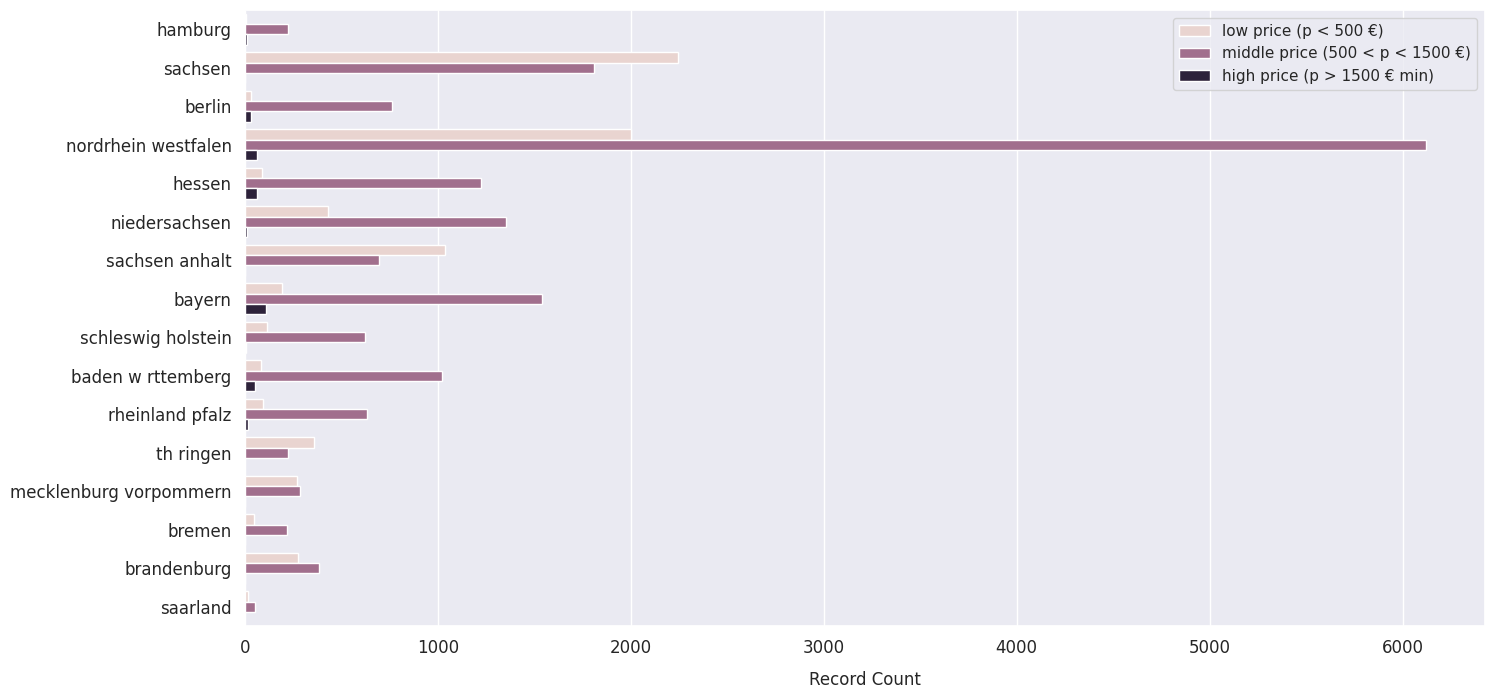

In [ ]:
rent_type = lambda x:((0,1)[x > 500],2)[x >= 1500]

df_dist= df_mix.copy()
df_dist['price_level'] = df_dist['totalRent'].apply(rent_type)

fig = plt.figure(1, figsize=(16,8))
ax = sns.countplot(data=df_dist, y="regio1", hue='price_level')
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Record Count', fontsize=12, labelpad=10)

L = plt.legend()
L.get_texts()[0].set_text('low price (p < 500 €)')
L.get_texts()[1].set_text('middle price (500 < p < 1500 €)')
L.get_texts()[2].set_text('high price (p > 1500 € min)')
plt.show()

## Categorial Encoding

In [ ]:
for col in set(cat_columns)- {'description','facilities', 'date'}:
    df_mix[col] = df_mix[col].astype('category')
    df_mix[col] = df_mix[col].cat.codes

df_mix.head(5)

,scoutId,garden,telekomUploadSpeed,clean_description,property_age,baseRentRange,serviceCharge,geo_plz,clean_facilities,interiorQual,...,street,condition,pricetrend,livingSpaceRange,streetPlain,thermalChar,yearConstructedRange,lift,floor,cellar
0,14637,0,40.0,freuen grundsanierte wohnung decken gespachtel...,71,5.0,140.0,872,kabelanschluss warmwasser zentral heizanlage k...,1,...,1431,2,6.0,2.0,1425,142.0,2.0,0,2.0,1
1,16156,0,40.0,laminatboden wohn schlafr umen boden fenster w...,119,2.0,170.0,385,vermietung steht obergescho gepflegten familie...,1,...,3933,8,1.0,3.0,3927,101.0,1.0,0,1.0,1
2,18787,0,40.0,luxuri neubauquartier direkt luisenpark giger ...,5,7.0,150.0,427,ruhig gelegen trotz zentraler lage zimmer park...,0,...,11210,0,7.0,2.0,11193,115.0,9.0,1,3.0,1
3,490,0,10.0,zimmer wohnung zentraler lage leipzig mockau e...,58,2.0,70.0,153,neuer einbauk balkon stilgerechte wohnungseing...,3,...,12703,7,5.0,2.0,12696,115.0,4.0,0,2.0,1
4,24431,0,40.0,wohnfl verteilt zwei zimmer nnen alleine zweit...,60,1.0,127.0,1808,anschluss breitbandkabelnetz isolierverglaste ...,1,...,3596,1,3.0,2.0,3590,115.0,2.0,0,2.0,1


## Correlations

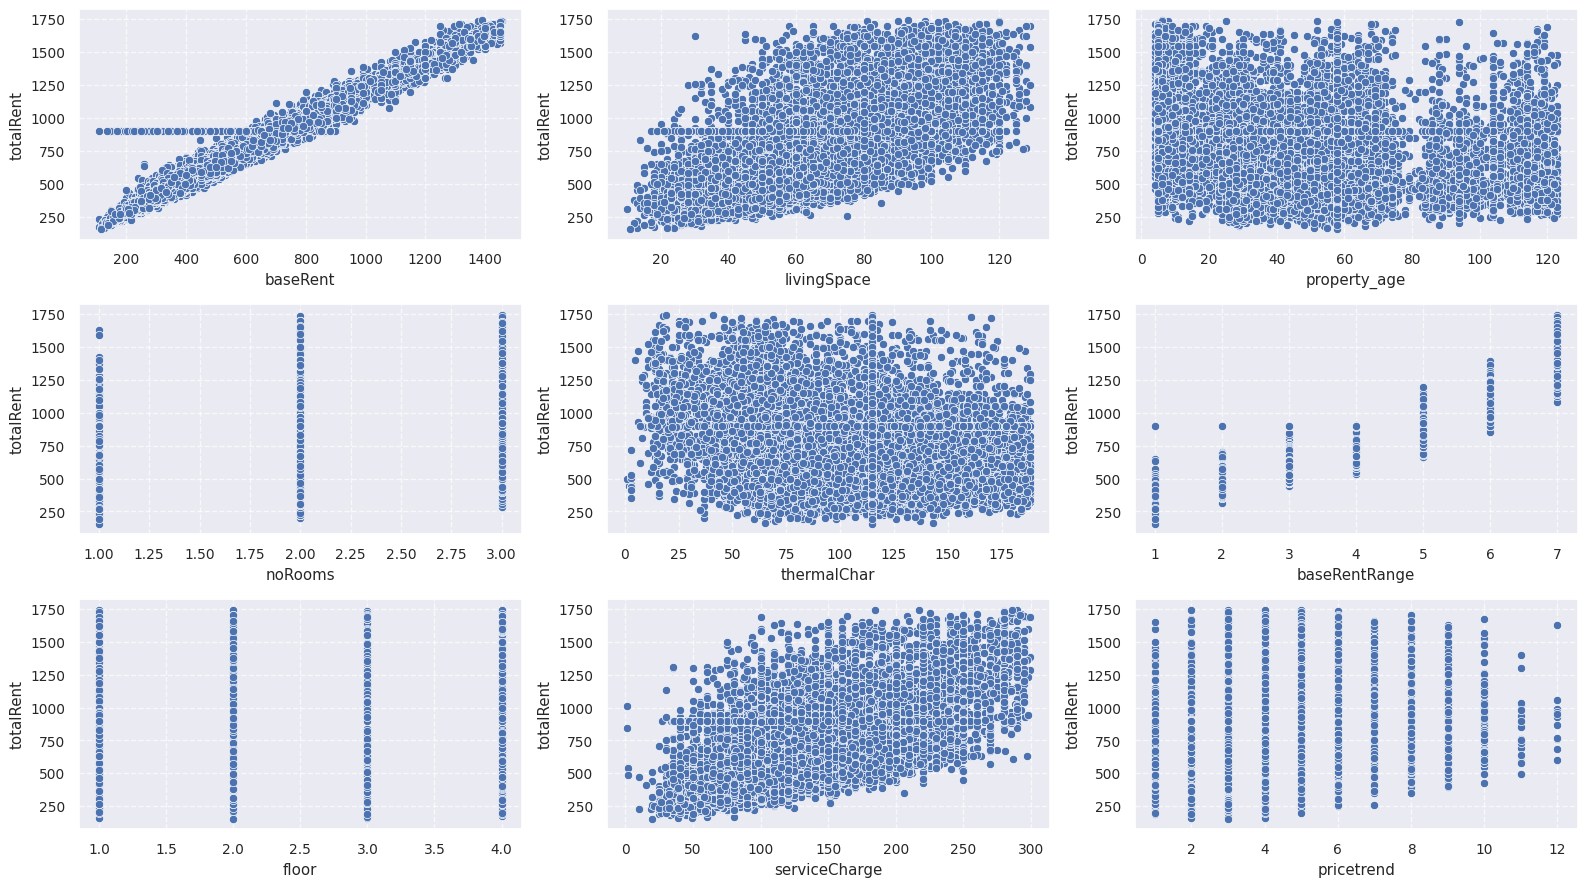

In [ ]:
sns.set(font_scale=0.9)
fig, axes = plt.subplots(3, 3, figsize=(16, 9))
axes[0, 0].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 2].grid(True, linestyle='--', alpha=0.7)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].grid(True, linestyle='--', alpha=0.7)
axes[2, 0].grid(True, linestyle='--', alpha=0.7)
axes[2, 1].grid(True, linestyle='--', alpha=0.7)
axes[2, 2].grid(True, linestyle='--', alpha=0.7)

sns.scatterplot( data=df_mix, x=df_mix['baseRent'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[0, 0])
sns.scatterplot( data=df_mix, x=df_mix['livingSpace'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[0, 1])
sns.scatterplot( data=df_mix, x=df_mix['property_age'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[0, 2])
sns.scatterplot( data=df_mix, x=df_mix['noRooms'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[1, 0])
sns.scatterplot( data=df_mix, x=df_mix['thermalChar'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[1, 1])
sns.scatterplot( data=df_mix, x=df_mix['baseRentRange'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[1, 2])
sns.scatterplot( data=df_mix, x=df_mix['floor'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[2, 0])
sns.scatterplot( data=df_mix, x=df_mix['serviceCharge'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[2, 1])
sns.scatterplot( data=df_mix, x=df_mix['pricetrend'], y=df_mix['totalRent'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[2, 2])

fig.tight_layout()
plt.show()

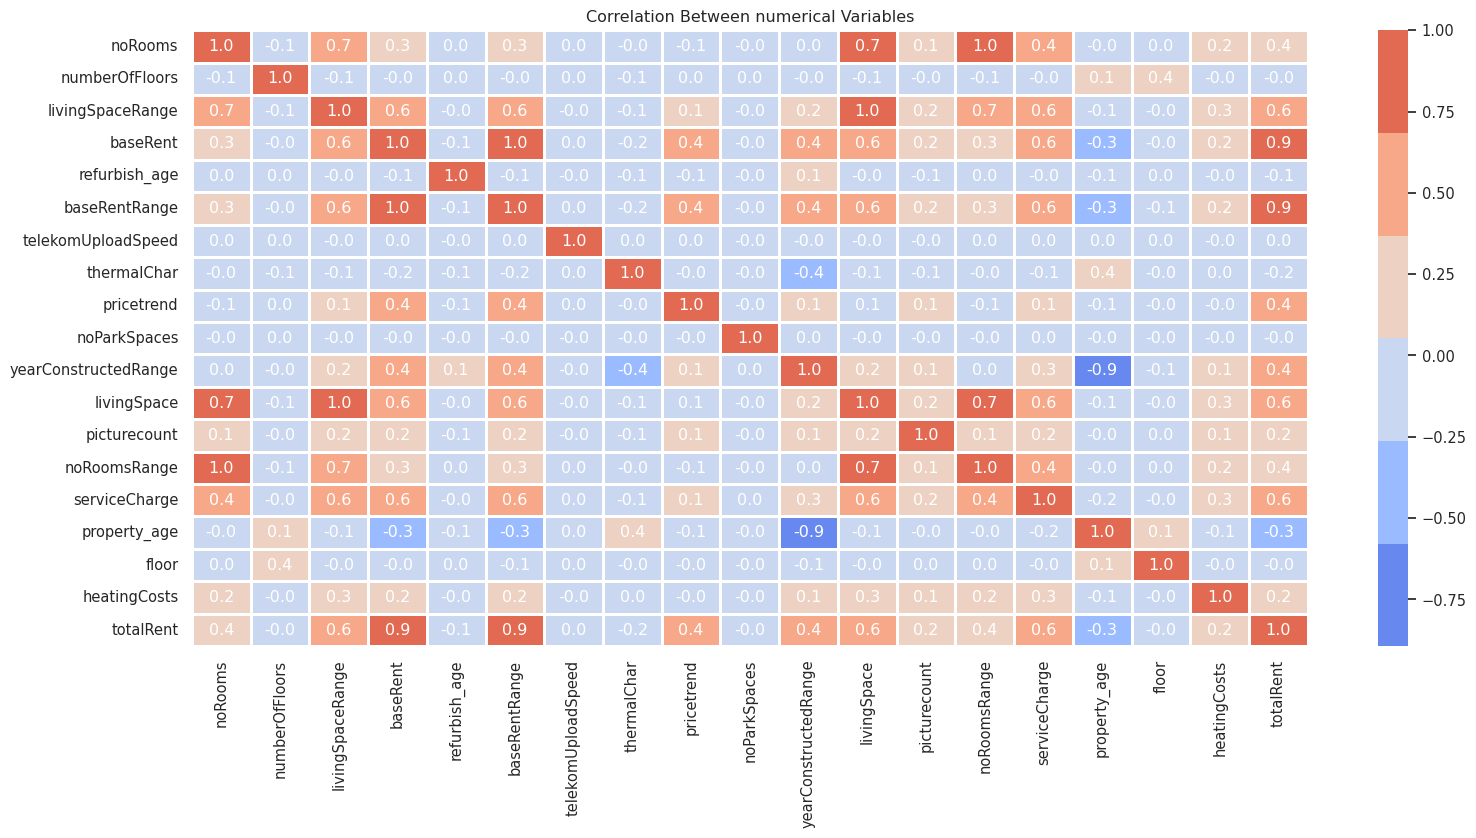

In [ ]:
df_corr = df_mix[list(set(df_num.columns)-set(['scoutId','totalRent']))+['totalRent']]
correlation = df_corr.corr()
sns.set(font_scale=0.96)
fig, ax = plt.subplots(figsize=(18, 8))

corr_heatmap = sns.heatmap(correlation, cmap=sns.color_palette("coolwarm"),
                           linewidth=1, edgecolor="k", annot=False, ax=ax)

for i in range(correlation.shape[0]):
    for j in range(correlation.shape[1]):
        ax.text(j + 0.5, i + 0.5, f"{correlation.iloc[i, j]:.1f}",
               ha='center', va='center', color='white')

plt.title("Correlation Between numerical Variables")
plt.show()

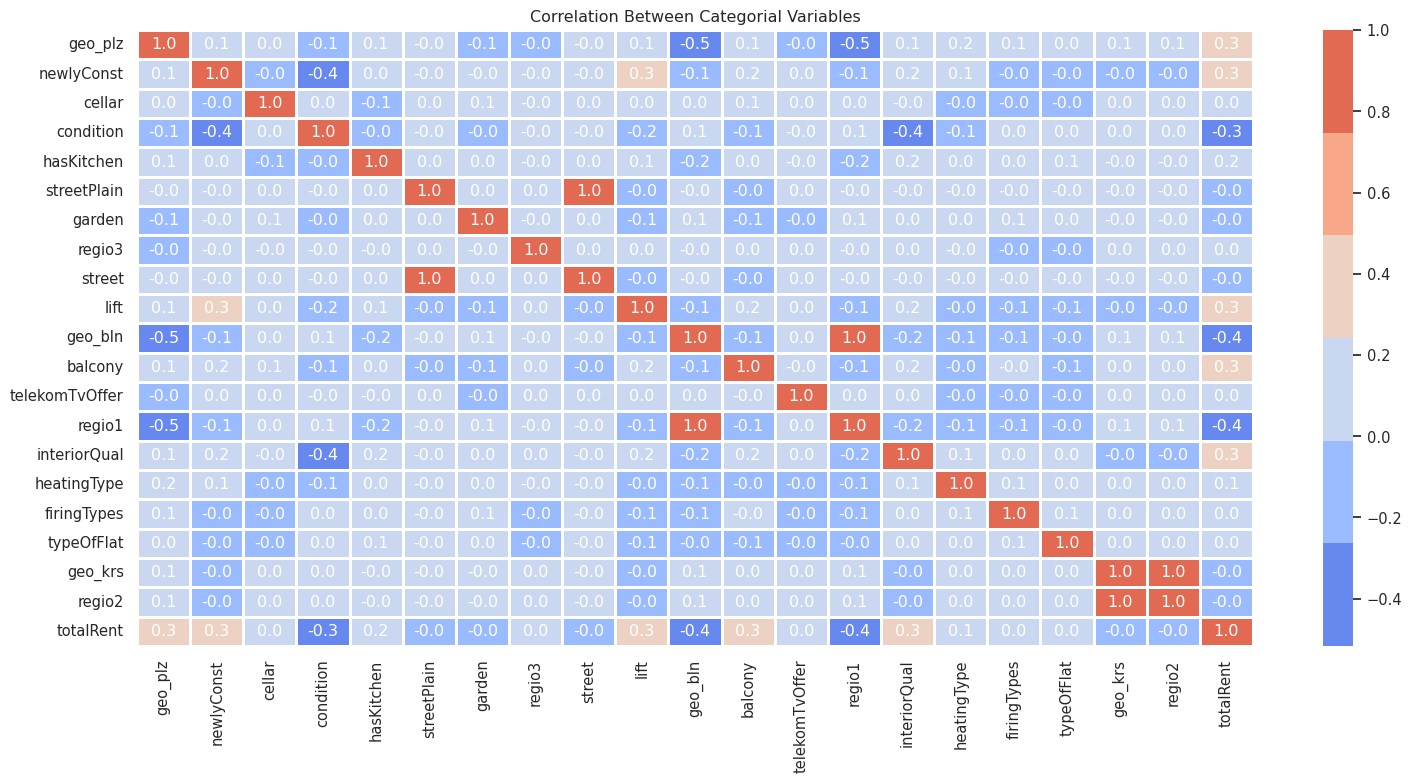

In [ ]:
df_corr = df_mix[list(set(df_cat.columns)-set(['scoutId', 'description', 'date', 'facilities']))+['totalRent']]
df_corr= df_corr.apply(pd.to_numeric)
correlation = df_corr.corr()
sns.set(font_scale=0.96)
fig, ax = plt.subplots(figsize=(18, 8))

corr_heatmap = sns.heatmap(correlation, cmap=sns.color_palette("coolwarm"),
                           linewidth=1, edgecolor="k", annot=False, ax=ax)

for i in range(correlation.shape[0]):
    for j in range(correlation.shape[1]):
        ax.text(j + 0.5, i + 0.5, f"{correlation.iloc[i, j]:.1f}",
                ha='center', va='center', color='white')

plt.title("Correlation Between Categorial Variables")
plt.show()

## SHAP Feature Importance

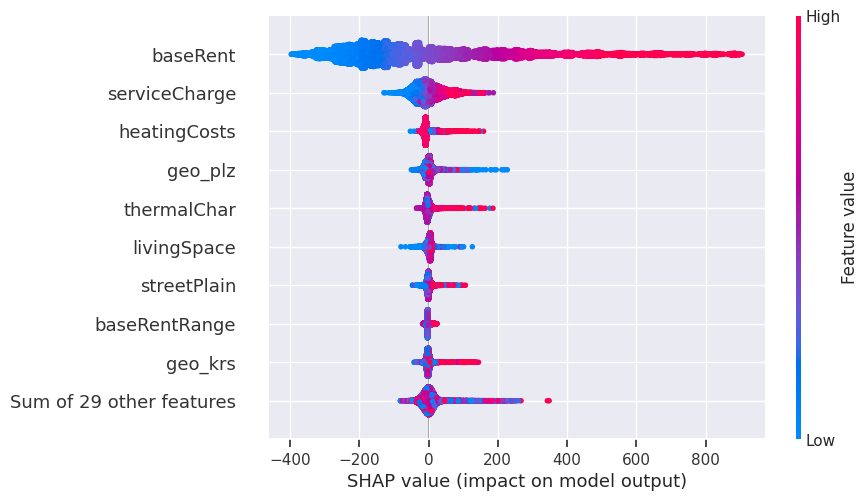

In [ ]:
X= df_mix[list(set(df_mix.columns)-set(['totalRent', 'clean_description','clean_facilities', 'scoutId']))]
X= X.apply(pd.to_numeric)

y= df_mix['totalRent']

model = xgboost.XGBRegressor().fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

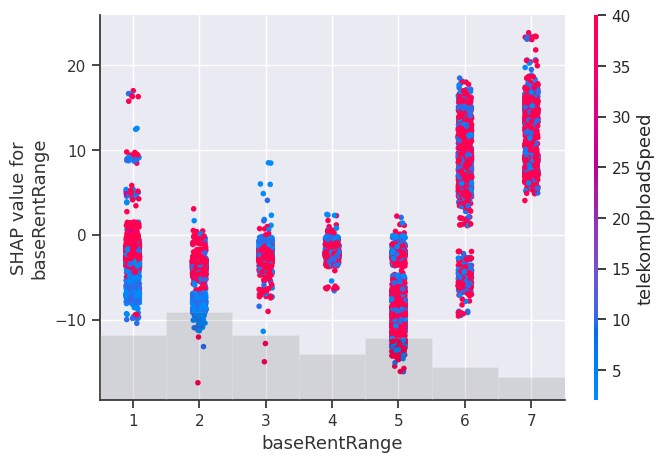

In [ ]:
shap.plots.scatter(shap_values[:, "baseRentRange"], color=shap_values)

## Rent Price Prediction without Text

Remove "baseRentRange" and "baseRent" to avoid data leakage. <br>

We can exclude dependent features like "livingSpaceRange", "noRoomsRange", "geo_bln", "regio2" and "streetPlain".

In [ ]:
ft= list(set(df_mix.columns)-set(['totalRent', 'clean_description','clean_facilities', 'date', 'scoutId',
                                   'baseRentRange', 'baseRent']))

X_reg=df_mix[ft]
X_scaled_reg= StandardScaler().fit_transform(X_reg)
y_reg=df_mix['totalRent']

In [ ]:
def mae_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return    mean_absolute_error(y, y_pred)


def r2_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return    r2_score(y, y_pred)

def Root_mean_squared_err(estimator, x, y):
    yPred = estimator.predict(x)
    return    sqrt(mean_squared_error(y, yPred))


def relative_root_mean_squared_error(estimator, x,y) :
    pred = estimator.predict(x)
    num = np.sum(np.square(y - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def evaluate_model(X, y, model):

   cval = KFold(n_splits=2, shuffle=True, random_state=42)
   r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=cval, n_jobs=-1)
   mae_scores= cross_val_score(model, X, y, scoring=mae_scorer, cv=cval, n_jobs=-1)
   root_scores= cross_val_score(model, X, y, scoring= Root_mean_squared_err, cv=cval, n_jobs=-1)
   pr_scores= cross_val_score(model, X, y, scoring= relative_root_mean_squared_error, cv=cval, n_jobs=-1)
   return r2_scores, mae_scores , root_scores, pr_scores


def clf_models():

    models, names = list(), list()

    models.append(LinearRegression())
    names.append('LinR')

    models.append(xgboost.XGBRegressor(max_depth=6, n_estimators=200, random_state=0))
    names.append('XGB')

    models.append(DecisionTreeRegressor(max_depth=6))
    names.append('DTR')

    models.append(KNeighborsRegressor(n_neighbors=2))
    names.append('KNN')

    models.append(GradientBoostingRegressor(max_depth=6, random_state=0))
    names.append('GBR')

    models.append(RandomForestRegressor(max_depth=6, random_state=0))
    names.append('RNDR')

    return models, names


models, names = clf_models()
accu_collect=[]

for i in range(len(names)):
   steps = [('m', models[i])]
   pipeline = Pipeline(steps=steps)

   r2_scores, mae_scores , root_scores, pr_scores = evaluate_model(X_scaled_reg ,y_reg, pipeline)
   print('====> %s MAE: %.4f   RMSE: %.4f  RRMSE: %.4f    R2: %.4f'       % (names[i],  np.mean(mae_scores), np.mean(root_scores), np.mean(pr_scores), np.mean(r2_scores) ))
   accu_collect.append(list(mae_scores))

====> LinR MAE: 118.0081   RMSE: 159.6853  RRMSE: 0.2141    R2: 0.6942
====> XGB MAE: 91.8277   RMSE: 128.2581  RRMSE: 0.1695    R2: 0.8027
====> DTR MAE: 131.7054   RMSE: 174.5204  RRMSE: 0.2347    R2: 0.6347
====> KNN MAE: 140.2714   RMSE: 191.8477  RRMSE: 0.2593    R2: 0.5586
====> GBR MAE: 92.6339   RMSE: 128.4426  RRMSE: 0.1710    R2: 0.8021
====> RNDR MAE: 120.9855   RMSE: 160.6694  RRMSE: 0.2169    R2: 0.6904


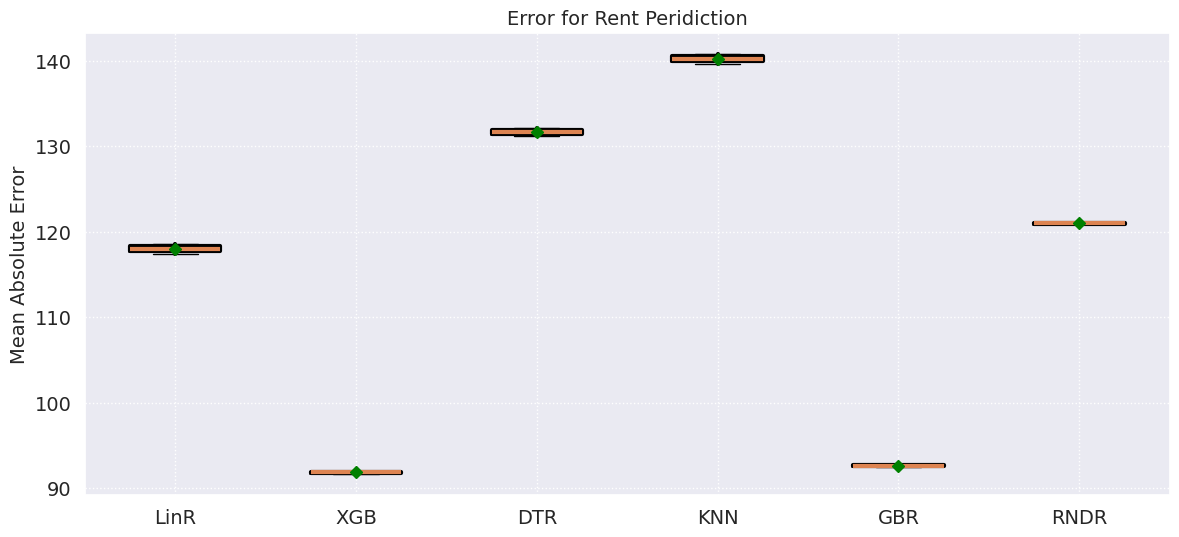

In [ ]:
fig = plt.figure()
fig.set_size_inches(14, 6)
plt.ylabel('Mean Absolute Error', fontsize=14)
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  linestyle='none')
whiskerprops = dict(linewidth=3, color='black')
meanpointprops = dict(marker='D', markeredgecolor='green',
                      markerfacecolor='green')

plt.boxplot(accu_collect ,labels= names, showmeans=True, whiskerprops=whiskerprops, boxprops=whiskerprops,
                                                       meanprops=meanpointprops,  medianprops={"linewidth": 3,  "solid_capstyle": "butt"})

plt.grid(visible=True, linestyle=':')
plt.tick_params(axis='both',labelsize=14)
plt.title('Error for Rent Peridiction', fontsize=14)
plt.show()

## SHAP Interpretation

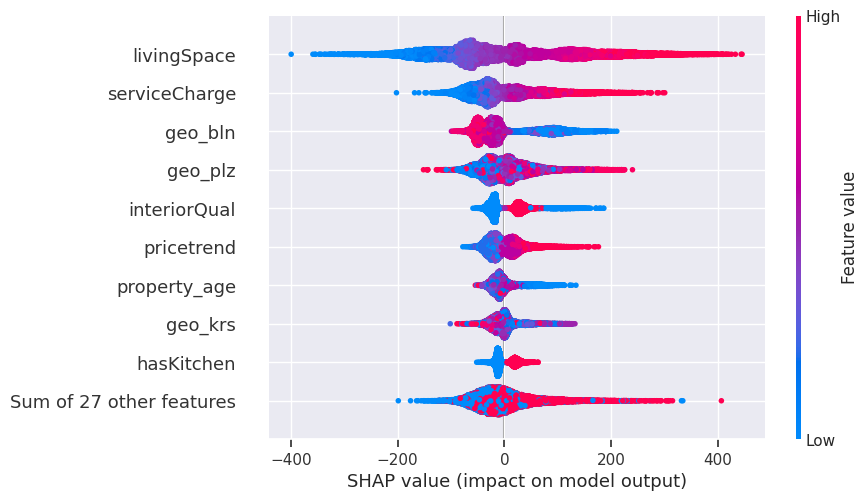

In [ ]:
model = xgboost.XGBRegressor().fit(X_reg, y)
explainer = shap.Explainer(model)
shap_values = explainer(X_reg)
shap.plots.beeswarm(shap_values)

# Rental Prediction with Text

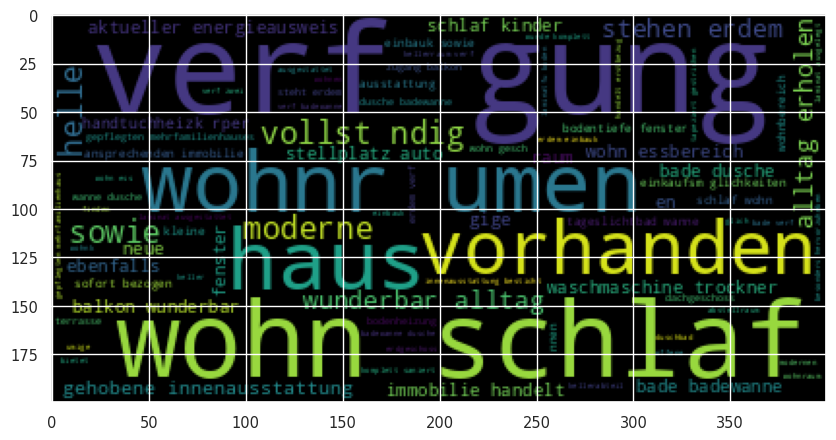

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

def text_control(doc):

    doc = doc.replace("befindet", "")
    doc = doc.replace("befinden", "")
    doc = doc.replace("liegt", "")
    doc = doc.replace("wohnung", "")
    doc = doc.replace("zimmer", "")

    return doc

df_txt= df_mix.copy()
df_txt['full_text']= df_txt['clean_description']+ df_txt['clean_facilities']
df_txt['full_text']= df_txt['full_text'].apply(lambda x: text_control(x))

fig, ax = plt.subplots(figsize=(10, 6))

wordcloud2 = WordCloud().generate(' '.join(df_txt['full_text']))

plt.imshow(wordcloud2)
plt.show()

## TF-IDF Encoding

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=1,  max_features= 1000, max_df = 0.9)
tfidf = tfidf_vectorizer.fit_transform(df_txt['full_text'])

y = df_txt['totalRent']

cols= list( set(df_mix.columns)- set(['description','facilities', 'date', 'scoutId']) )

ft= list(set(df_txt.columns)-set(['scoutId','totalRent' , 'full_text','clean_description','clean_facilities', 'date', "baseRentRange", "baseRent"]))
random.shuffle(ft)

df_feat=df_txt[ft]

tfidf_arr= tfidf.todense()
df_tf=pd.DataFrame(data=tfidf_arr[0:,0:],
            index=[i for i in range(tfidf_arr.shape[0])],
            columns=['f'+str(i) for i in range(tfidf_arr.shape[1])])


feat_scaled= StandardScaler().fit_transform(df_feat)
X_scaled_tfidf= np.concatenate((feat_scaled, tfidf.toarray()), axis=1)

df_tfidf= pd.concat([df_feat, df_tf], axis=1)
df_tfidf.head(8)

,firingTypes,balcony,noRooms,geo_plz,hasKitchen,regio1,newlyConst,noRoomsRange,heatingType,geo_krs,...,f990,f991,f992,f993,f994,f995,f996,f997,f998,f999
0,6,1,3.0,872,0,5,0,3.0,0,138,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,16,0,3.0,385,0,12,0,3.0,5,417,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,6,1,2.0,427,1,2,1,2.0,4,37,...,0.080062,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,6,1,2.0,153,1,12,0,2.0,0,200,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,34,1,2.0,1808,0,9,0,2.0,9,304,...,0.142409,0.0,0.0,0.0,0.0,0.0,0.120818,0.0,0.0,0.0
5,34,1,3.0,2635,1,6,0,3.0,0,403,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,16,0,2.0,6,0,12,0,2.0,0,82,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
7,16,0,3.0,1766,0,9,0,3.0,9,413,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [ ]:
def mae_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return    mean_absolute_error(y, y_pred)


def r2_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return    r2_score(y, y_pred)

def Root_mean_squared_err(estimator, x, y):
    yPred = estimator.predict(x)
    return    sqrt(mean_squared_error(y, yPred))


def relative_root_mean_squared_error(estimator, x,y) :
    pred = estimator.predict(x)
    num = np.sum(np.square(y - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def evaluate_model(X, y, model):

   cval = KFold(n_splits=3, shuffle=True, random_state=42)
   r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=cval, n_jobs=-1)
   mae_scores= cross_val_score(model, X, y, scoring=mae_scorer, cv=cval, n_jobs=-1)
   root_scores= cross_val_score(model, X, y, scoring= Root_mean_squared_err, cv=cval, n_jobs=-1)
   pr_scores= cross_val_score(model, X, y, scoring= relative_root_mean_squared_error, cv=cval, n_jobs=-1)
   return r2_scores, mae_scores , root_scores, pr_scores


def clf_models():

    models, names = list(), list()

    models.append(LinearRegression())
    names.append('LinR')

    models.append(xgboost.XGBRegressor(max_depth=6, random_state=0))
    names.append('XGB')

    models.append(DecisionTreeRegressor(max_depth=6))
    names.append('DTR')

    models.append(KNeighborsRegressor(n_neighbors=2))
    names.append('KNN')

    return models, names


models, names = clf_models()
accu_collect=[]

for i in range(len(names)):
   steps = [('m', models[i])]
   pipeline = Pipeline(steps=steps)

   r2_scores, mae_scores , root_scores, pr_scores = evaluate_model(X_scaled_tfidf, y, pipeline)
   print('====> %s MAE: %.4f   RMSE: %.4f  RRMSE: %.4f    R2: %.4f'       % (names[i],  np.mean(mae_scores), np.mean(root_scores), np.mean(pr_scores), np.mean(r2_scores) ))
   accu_collect.append(list(mae_scores))

====> LinR MAE: 112.3120   RMSE: 150.8097  RRMSE: 0.2011    R2: 0.7270
====> XGB MAE: 92.7502   RMSE: 129.0482  RRMSE: 0.1715    R2: 0.8001
====> DTR MAE: 131.4912   RMSE: 174.6307  RRMSE: 0.2346    R2: 0.6340
====> KNN MAE: 135.6454   RMSE: 187.0913  RRMSE: 0.2528    R2: 0.5799
